# Play Store Applications Analysis

# UPDATE - Fix These:

* When preprocessing the model, OneHotEncoding should have been used rather than the LabelEncoder. This is because a bias may exist between numbers in 0-33 rather than a matrix of 0 and 1 for category, genre, and content rating.
* A K-fold Cross Validation set should have been used to find tune the model before using the test set.
* Other models could have been used during the cross validation process to determine the best binary classifier model to use.
* ROC AUC or precision/recall curves should have been created to determine the best decision threshold for the model.

# Required Libraries and model classifier :

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns #plotting
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
init_notebook_mode(connected=True)

# Look at The Data_Set :

In [36]:
df_reviews = pd.read_csv("googleplaystore_user_reviews.csv")
df_reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [122]:
df_apps = pd.read_csv("googleplaystore.csv")
df_apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Data_preprocessing_Steps :

In [38]:
categories = list(df_apps["Category"].unique())

In [39]:
print("There are {0:.0f} categories! (Excluding/Removing Category 1.9)".format(len(categories)-1))

There are 33 categories! (Excluding/Removing Category 1.9)


In [40]:
print(categories)

['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY', 'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION', 'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE', 'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME', 'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL', 'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL', 'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER', 'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION', '1.9']


In [41]:
#Remove Category 1.9
categories.remove('1.9')

In [42]:
a = df_apps.loc[df_apps["Category"] == "1.9"]

In [43]:
print(a.head())

                                           App Category  Rating Reviews  \
10472  Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0    3.0M   

         Size Installs Type     Price Content Rating             Genres  \
10472  1,000+     Free    0  Everyone            NaN  February 11, 2018   

      Last Updated Current Ver Android Ver  
10472       1.0.19  4.0 and up         NaN  


In [44]:
a.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [45]:
print("This mislabeled app category affects {} app at index {}.".format(len(a),int(a.index.values)))

This mislabeled app category affects 1 app at index 10472.


In [123]:
df_apps['Rating'].isnull().sum()

1474

In [124]:
df_apps = df_apps.drop(df_apps[df_apps['Rating'].isnull()].index, axis=0)

# The Exploratory_Data_Analysis (EDA step) : 

In [125]:
df_apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9367 entries, 0 to 10840
Data columns (total 13 columns):
App               9367 non-null object
Category          9367 non-null object
Rating            9367 non-null float64
Reviews           9367 non-null object
Size              9367 non-null object
Installs          9367 non-null object
Type              9367 non-null object
Price             9367 non-null object
Content Rating    9366 non-null object
Genres            9367 non-null object
Last Updated      9367 non-null object
Current Ver       9363 non-null object
Android Ver       9364 non-null object
dtypes: float64(1), object(12)
memory usage: 1.0+ MB


In [126]:
df_apps["Rating"].describe()

count    9367.000000
mean        4.193338
std         0.537431
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max        19.000000
Name: Rating, dtype: float64

In [127]:
layout = go.Layout(
    xaxis=dict(title='Ratings'),yaxis=dict(title='Number of Apps'))
data = [go.Histogram(x=df_apps["Rating"])]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic histogram')

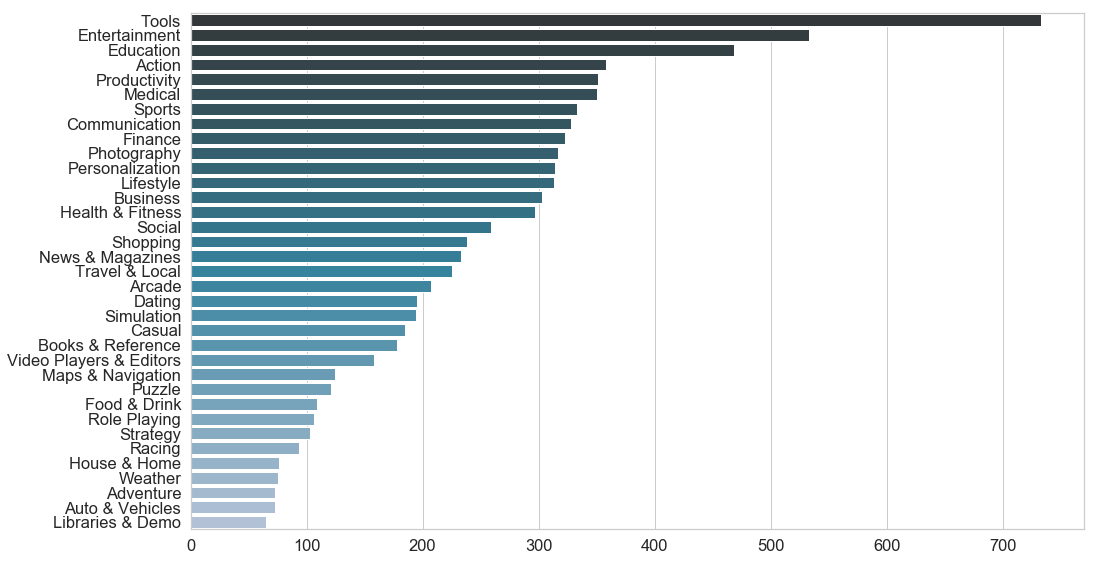

In [51]:
#Show top 35 app genres
plt.figure(figsize=(16, 9.5))
genres = df_apps["Genres"].value_counts()[:35]
ax = sns.barplot(x=genres.values, y=genres.index, palette="PuBuGn_d")

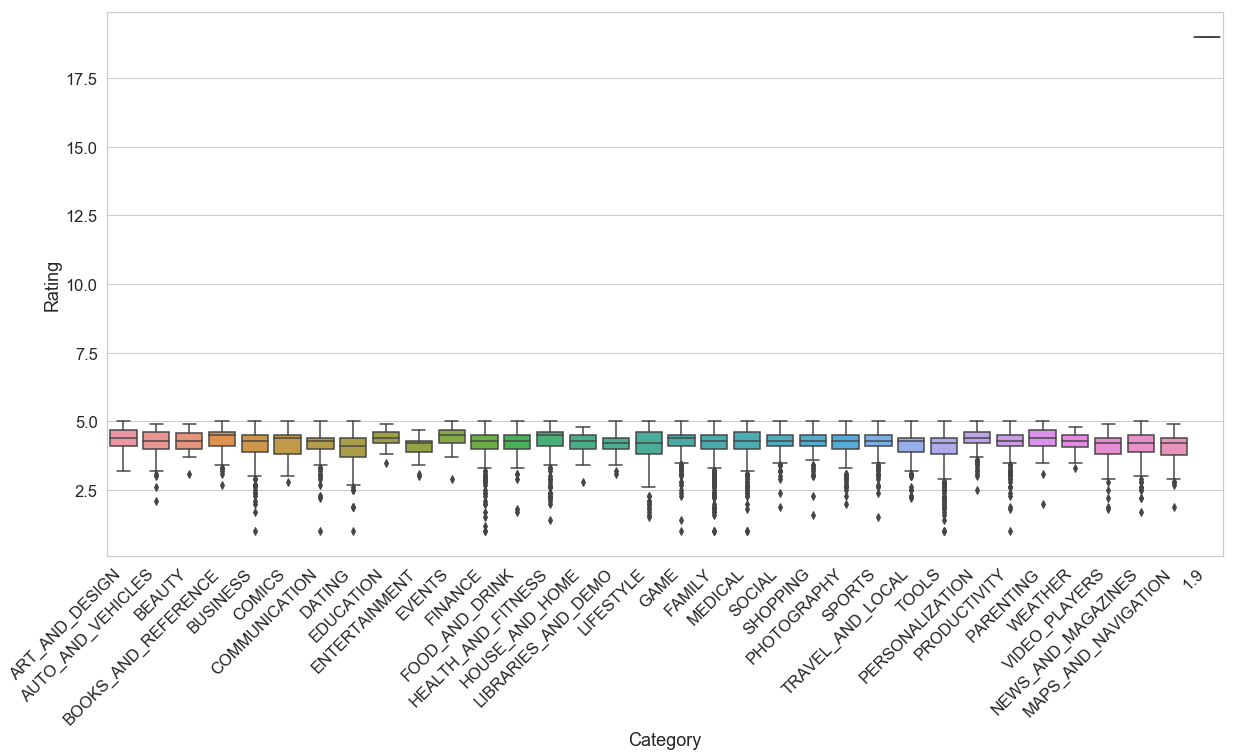

In [128]:
sns.set(rc={'figure.figsize':(20,10)}, font_scale=1.5, style='whitegrid')
ax = sns.boxplot(x="Category",y="Rating",data=df_apps)
labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=45,ha='right')

All of the categories have close rating averages. In order to further define which categories are the highest rated, we will only look at the data for each category that has more than or equal to 4.0 in rating.

In [129]:
#Cut away rows which have < 4.0 ratings
highRating = df_apps.copy()
highRating = highRating.loc[highRating["Rating"] >= 4.0]
highRateNum = highRating.groupby('Category')['Rating'].nunique()
highRateNum

Category
1.9                     1
ART_AND_DESIGN         10
AUTO_AND_VEHICLES       8
BEAUTY                 10
BOOKS_AND_REFERENCE    11
BUSINESS               11
COMICS                 10
COMMUNICATION          10
DATING                 11
EDUCATION              10
ENTERTAINMENT           8
EVENTS                 11
FAMILY                 11
FINANCE                11
FOOD_AND_DRINK         10
GAME                   11
HEALTH_AND_FITNESS     11
HOUSE_AND_HOME          9
LIBRARIES_AND_DEMO      9
LIFESTYLE              11
MAPS_AND_NAVIGATION    10
MEDICAL                11
NEWS_AND_MAGAZINES     11
PARENTING              11
PERSONALIZATION        11
PHOTOGRAPHY            11
PRODUCTIVITY           11
SHOPPING               10
SOCIAL                 11
SPORTS                 11
TOOLS                  11
TRAVEL_AND_LOCAL       10
VIDEO_PLAYERS          10
WEATHER                 9
Name: Rating, dtype: int64

There are many categories of apps that are equal in terms of being the highest rated. This is great, however, the interest should lie within the app categories which have the lowest number of high ratings. These poorly rated apps deserve more attention because if a new sleek new app in that category were to be put on the app store, then the developers could satisfy the demand for innovation in this area. In this case, The Categories of Importance are "AUTO_AND_VEHICLES"and "ENTERTAINMENT."

Now to analyze the apps which would produce the most ad revenue

One parameter that would affect ad revenue the most is the number of installs an app has. More installs means more people are opening the app and viewing the embedded ads, hence, there is more money being made. A free application may lead to more installs, however, other parameters may alter how many installs an app will have. Let's see if there is a correlation between installs and other parameters!

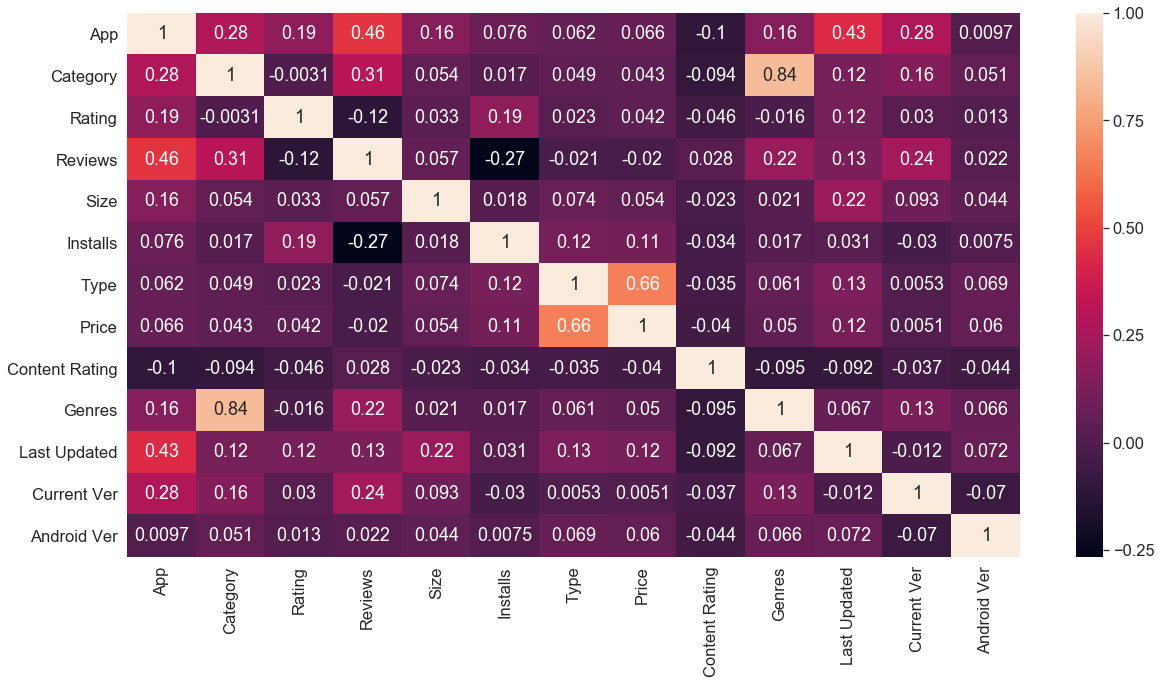

In [130]:
df_apps.dtypes
df_apps["Type"] = (df_apps["Type"] == "Paid").astype(int)
corr = df_apps.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,annot=True)

Above, we can see that Installs and Reviews has the strongest inverse correlation. This is reasonable because more reviews are conducted on apps that are the most popular. Since Installs was not correlated to Type, this disproves our intuition that free apps lead to more installs. Since the Installs parameter is independent and not correlated to any other parameters, we must only use Installs to show the popularity of an app. Apps with larger amounts of installs would generate the most revenue. Let's take a look at the Top 40 Apps that businesses should consider signing advertising deals with!

In [182]:
#Extract App, Installs, & Content Rating from df_apps
popApps = df_apps.copy()
popApps = popApps.drop_duplicates()

In [183]:
popApps.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type                int64
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [184]:
popApps.Installs

0            10,000+
1           500,000+
2         5,000,000+
3        50,000,000+
4           100,000+
5            50,000+
6            50,000+
7         1,000,000+
8         1,000,000+
9            10,000+
10        1,000,000+
11        1,000,000+
12       10,000,000+
13          100,000+
14          100,000+
15            5,000+
16          500,000+
17           10,000+
18        5,000,000+
19       10,000,000+
20          100,000+
21          100,000+
22          500,000+
24           50,000+
25           10,000+
26          500,000+
27          100,000+
28           10,000+
29          100,000+
30          100,000+
            ...     
10795       100,000+
10796     1,000,000+
10797     1,000,000+
10799       100,000+
10800         5,000+
10801         1,000+
10802        10,000+
10803     1,000,000+
10804       100,000+
10805           100+
10809     1,000,000+
10810           100+
10812         1,000+
10814        50,000+
10815       500,000+
10817       100,000+
10819        

just see an error message before integer conversion

In [185]:
popApps["Installs"] = popApps["Installs"].astype("int64")

ValueError: invalid literal for int() with base 10: '10,000+'

In [186]:
#Remove characters preventing values from being floats and integers
popApps["Installs"] = popApps["Installs"].str.replace("+","").str.replace(",","")

In [187]:
popApps.Installs

0           10000
1          500000
2         5000000
3        50000000
4          100000
5           50000
6           50000
7         1000000
8         1000000
9           10000
10        1000000
11        1000000
12       10000000
13         100000
14         100000
15           5000
16         500000
17          10000
18        5000000
19       10000000
20         100000
21         100000
22         500000
24          50000
25          10000
26         500000
27         100000
28          10000
29         100000
30         100000
           ...   
10795      100000
10796     1000000
10797     1000000
10799      100000
10800        5000
10801        1000
10802       10000
10803     1000000
10804      100000
10805         100
10809     1000000
10810         100
10812        1000
10814       50000
10815      500000
10817      100000
10819        5000
10820        1000
10826     5000000
10827        5000
10828       10000
10829       10000
10830      100000
10832      100000
10833     

now check the error message again

In [188]:
popApps["Installs"] = popApps["Installs"].astype("int64")

ValueError: invalid literal for int() with base 10: 'Free'

In [190]:
pd.to_numeric(popApps['Installs'])

ValueError: Unable to parse string "Free" at position 8644

just check this error it may happen only when we have 'free' in our dataset(in installs column) instead number